# Power Analysis

Using a 2-factor ANOVA on the condition assignment and evidence level, what sample size do we need to achive $\beta=0.2$ given a [small-medium effect size](http://methods.sagepub.com/Reference//the-sage-encyclopedia-of-communication-research-methods/i4505.xml) on the affirmation rate of rumours ($\eta^2=0.03$)?

> power is simply the proportion of times that we are able to reject the null hypothesis (remembering that we control the population means and we know that there is a true difference)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("whitegrid",{'axes.spines.left' : False,
                           'axes.spines.right': False,
                           'axes.spines.top': False,
                           'grid.linestyle': ':'})
sns.set_context("talk")
fp = "../data/artifacts/power_simulation-alpha=0.05.csv"

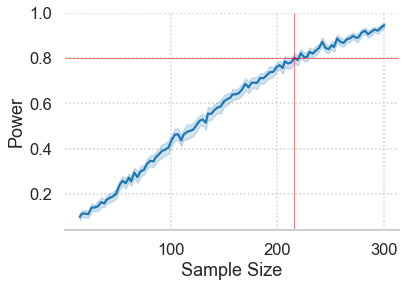

In [6]:
power_sim = pd.read_csv(fp)
g = sns.lineplot(data=power_sim,
                 x="sample_size",
                 y="power")
thresh = power_sim.groupby("sample_size")["power"].mean()
sample_size = thresh[thresh >= 0.8].head(1).index[0]
g.set(xlabel="Sample Size",
      ylabel="Power")
g.axhline(y=0.8,c='red',linewidth=0.5)
g.axvline(x=sample_size,c='red',linewidth=0.5)
# g.text(sample_size-10,
#        0.83,
#        f"Min Sample: {sample_size}",
#        color='red',
#        fontsize="small",
#        horizontalalignment="right")
# g.figure.savefig("../figures/artifacts/power_simulation-alpha=0.05-2.pdf")

## Simulation

In [7]:
participants = pd.read_csv("../data/processed/mock_data/participant-schema.csv",index_col=0)
posts = pd.read_csv("../data/processed/mock_data/posts-schema.csv",index_col=0)
group_cols = ["PROLIFIC_ID","SESSION_ID","treatment","warning","evidence","code"]
reshare_rates = pd.DataFrame(posts.groupby(group_cols)["reshared"].sum() / posts.groupby(group_cols)["reshared"].count()).reset_index()
# Nicely format labels
reshare_rates['treatment'] = reshare_rates['treatment'].replace({False: 'Control',
                                                                 True: 'Treatment'})
reshare_rates['code'] = reshare_rates['code'].str.title()
reshare_rates["evidence"] = reshare_rates["evidence"].str.title()
affirmation_rates = reshare_rates[reshare_rates["code"]=="Affirms"]
affirmation_rates

,PROLIFIC_ID,SESSION_ID,treatment,warning,evidence,code,reshared
0,1,1,Treatment,False,High,Affirms,0.800000
4,1,1,Treatment,False,Low,Affirms,0.000000
7,1,1,Treatment,True,Low,Affirms,0.333333
8,2,2,Treatment,False,High,Affirms,0.333333
12,2,2,Treatment,False,Low,Affirms,0.000000
...,...,...,...,...,...,...,...
2927,497,497,Treatment,True,Low,Affirms,0.000000
2928,498,498,Control,False,High,Affirms,0.800000
2931,498,498,Control,False,Low,Affirms,0.600000
2934,499,499,Control,False,High,Affirms,0.500000


In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from numba import jit

@jit
def get_effect(df):
    """
        Gets the effect size, and significance, 
        
        Effect size, eta squared, is derived from this pdf: https://stardock.cs.virginia.edu/empirical/resources/Brown28.pdf
    """
    moore_lm = ols('reshared ~ C(treatment)*C(evidence)',data=df).fit()
    table = sm.stats.anova_lm(moore_lm, typ=2)
    pval = table.iloc[2,3]
    eta_sqr = table.iloc[2,0]/table.iloc[3,0]
    return eta_sqr,pval

def power_simulation(df,sample_sizes,num_trials,trial_size,alpha=0.05):
    res = {"sample_size": [],
           "power": [],
           "avg_eta_sqr": []}
    for ss in tqdm(sample_sizes):
#         assert len(df) > ss, f"Sample size ({ss}) larger than dataframe ({len(df)})"
        effect_size = 0
        for _ in range(num_trials):
            num_rejections = 0
            for _ in range(trial_size):
                sampled_df = df.sample(n=ss)
                try:
                    eta_sqr, pval = get_effect(sampled_df)
                    effect_size += eta_sqr
                    if pval < alpha: num_rejections +=1
                except Exception:
                    trial_size-=1
            res["sample_size"].append(ss)
            res["power"].append(num_rejections/trial_size)
            res["avg_eta_sqr"].append(effect_size/trial_size)
    res = pd.DataFrame(res)
    return pd.DataFrame(res)

In [11]:
eta_sqr, pval = get_effect(affirmation_rates)
print(f"Effect size: {eta_sqr} (p={pval:0.2E})")

Effect size: 0.033182897860884464 (p=3.62E-08)


In [ ]:
sample_sizes = np.linspace(15,300,100,dtype=int)
num_trials = 50
trial_size = 30

power_sim = power_simulation(affirmation_rates,
                             sample_sizes,
                             num_trials,
                             trial_size)
power_sim.to_csv(fp,index=False)

In [17]:
## TODO: SEE IF THIS IS MORE APPROPRIATE
from pingouin import mixed_anova
t = affirmation_rates.reset_index()
t.mixed_anova(dv='reshared',
              between='treatment',
              within='evidence',
              subject='PROLIFIC_ID').round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,treatment,0.005,1,389,0.005,0.049,0.825,0.000,NaN
1,evidence,8.309,1,389,8.309,110.435,0.000,0.221,1.0
2,Interaction,2.809,1,389,2.809,37.343,0.000,0.088,NaN
